In [2]:
! pip install torchtext==0.8.1

  Using cached torchtext-0.8.1-cp37-cp37m-manylinux1_x86_64.whl (7.0 MB)
     |████████████████████████████████| 776.8 MB 18 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.12.0
    Uninstalling torchtext-0.12.0:
      Successfully uninstalled torchtext-0.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.7.1 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.7.1 which is incompatible.


In [3]:
import numpy as np
import pandas as pd
import spacy
import torch

In [4]:
#LOAD TASK 3 DATA
filename = '/content/task_3_event_prediction.tsv'
df = pd.read_csv(filename, delimiter='\t')
df = df[df['COUNTRY'] == 'India']

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
df.describe()

,ISO,YEAR,TIME_PRECISION,INTER1,INTER2,INTERACTION,LATITUDE,LONGITUDE,GEO_PRECISION,FATALITIES,TIMESTAMP
count,77892.0,77892.000000,77892.000000,77892.000000,77892.000000,77892.000000,77892.000000,77892.000000,77892.000000,77892.000000,7.789200e+04
mean,356.0,2019.454835,1.036949,5.439506,1.185205,51.410954,24.799296,80.374829,1.240487,0.077453,1.603590e+09
std,0.0,1.097523,0.195193,1.276693,2.425515,16.601485,7.175251,6.536730,0.468757,0.533503,2.667353e+07
min,356.0,2018.000000,1.000000,1.000000,0.000000,10.000000,7.007000,68.714000,1.000000,0.000000,1.552576e+09
25%,356.0,2019.000000,1.000000,6.000000,0.000000,57.000000,19.859250,75.203000,1.000000,0.000000,1.576855e+09
50%,356.0,2019.000000,1.000000,6.000000,0.000000,60.000000,26.214000,77.481500,1.000000,0.000000,1.618494e+09
75%,356.0,2020.000000,1.000000,6.000000,1.000000,60.000000,30.730000,85.136000,1.000000,0.000000,1.618957e+09
max,356.0,2022.000000,3.000000,8.000000,8.000000,80.000000,34.846000,96.994000,3.000000,40.000000,1.643151e+09


In [6]:
# Encode Protests as 1, rest as 0
df['EVENT_TYPE'] = np.where(df['EVENT_TYPE'] == 'Protests', 1, 0)
df = df[["EVENT_DATE", "INTER1", "INTER2", "INTERACTION", "EVENT_TYPE"]]
df['EVENT_DATE'] = pd.to_datetime(df['EVENT_DATE'])

protests_count = df.groupby('EVENT_DATE')['EVENT_TYPE'].agg('sum')
inter1 = df.groupby('EVENT_DATE')['INTER1'].agg('mean')
inter2 = df.groupby('EVENT_DATE')['INTER2'].agg('mean')
interaction = df.groupby('EVENT_DATE')['INTERACTION'].agg('mean')
total_count = df.groupby('EVENT_DATE')['EVENT_TYPE'].agg('count')

df = df.set_index('EVENT_DATE')

In [7]:
df['INTER1'] = inter1
df['INTER2'] = inter2
df['INTERACTION'] = interaction

In [8]:
df = df.drop('EVENT_TYPE', axis=1)

In [9]:
df = df.drop_duplicates()

In [10]:
df[:10]

,INTER1,INTER2,INTERACTION
EVENT_DATE,,,
2018-01-01,5.166667,1.366667,47.333333
2018-01-02,5.472727,0.418182,52.690909
2018-01-03,5.300000,1.125000,47.937500
2018-01-04,5.382353,1.441176,46.794118
2018-01-05,5.315789,0.631579,48.105263
2018-01-06,4.636364,1.727273,46.454545
2018-01-07,5.052632,1.368421,45.736842
2018-01-08,5.544118,0.823529,48.720588
2018-01-09,5.564103,0.589744,52.769231


In [11]:
df = df.reset_index()

In [12]:
df

,EVENT_DATE,INTER1,INTER2,INTERACTION
0,2018-01-01,5.166667,1.366667,47.333333
1,2018-01-02,5.472727,0.418182,52.690909
2,2018-01-03,5.300000,1.125000,47.937500
3,2018-01-04,5.382353,1.441176,46.794118
4,2018-01-05,5.315789,0.631579,48.105263
...,...,...,...,...
1477,2022-01-17,5.285714,1.285714,48.035714
1478,2022-01-18,5.268293,0.975610,49.926829
1479,2022-01-19,5.108108,1.297297,50.432432
1480,2022-01-20,5.675676,0.513514,53.135135


In [13]:
df['IS_PROTEST'] = np.where(protests_count > 0.6*total_count, 1, 0)

In [14]:
df[:10]

,EVENT_DATE,INTER1,INTER2,INTERACTION,IS_PROTEST
0,2018-01-01,5.166667,1.366667,47.333333,1
1,2018-01-02,5.472727,0.418182,52.690909,1
2,2018-01-03,5.300000,1.125000,47.937500,0
3,2018-01-04,5.382353,1.441176,46.794118,1
4,2018-01-05,5.315789,0.631579,48.105263,1
5,2018-01-06,4.636364,1.727273,46.454545,1
6,2018-01-07,5.052632,1.368421,45.736842,1
7,2018-01-08,5.544118,0.823529,48.720588,1
8,2018-01-09,5.564103,0.589744,52.769231,1
9,2018-01-10,5.360000,1.120000,49.680000,1


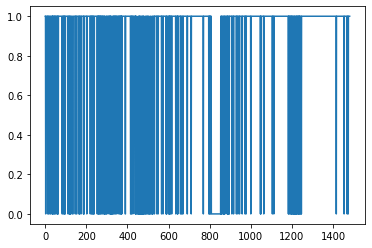

In [15]:
import matplotlib.pyplot as plt
plt.plot(df['IS_PROTEST'])

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
 
df[['INTER1', 'INTER2', 'INTERACTION']] = scaler.fit_transform(df[['INTER1', 'INTER2', 'INTERACTION']])

In [17]:
df = df.set_index('EVENT_DATE')

In [18]:
df

,INTER1,INTER2,INTERACTION,IS_PROTEST
EVENT_DATE,,,,
2018-01-01,0.756434,0.218667,0.676871,1
2018-01-02,0.836635,0.066909,0.813544,1
2018-01-03,0.791373,0.180000,0.692283,0
2018-01-04,0.812953,0.230588,0.663115,1
2018-01-05,0.795510,0.101053,0.696563,1
...,...,...,...,...
2022-01-17,0.787629,0.205714,0.694789,1
2022-01-18,0.783064,0.156098,0.743031,1
2022-01-19,0.741089,0.207568,0.755929,1


In [19]:
# FORMAT DATA
train_data = df[:int(df.shape[0]*0.7)]
test_data = df[int(df.shape[0]*0.7):]

In [20]:
train_data

,INTER1,INTER2,INTERACTION,IS_PROTEST
EVENT_DATE,,,,
2018-01-01,0.756434,0.218667,0.676871,1
2018-01-02,0.836635,0.066909,0.813544,1
2018-01-03,0.791373,0.180000,0.692283,0
2018-01-04,0.812953,0.230588,0.663115,1
2018-01-05,0.795510,0.101053,0.696563,1
...,...,...,...,...
2020-10-29,0.798519,0.197818,0.722171,1
2020-10-30,0.775151,0.140952,0.757046,1
2020-10-31,0.667187,0.306087,0.674468,1


In [21]:
def to_sequence(dataset, seq_size=7):  
  # number of past days we want to use to predict into the future
  n_past = 5
  # number of days we want to predict into the future
  n_future = 1
  trainX = []
  trainY = []

  for i in range(n_past, len(dataset) - n_future + 1):    
    trainX.append(dataset.iloc[i - n_past:i, 0:dataset.shape[1]])
    trainY.append(dataset.iloc[i + n_future - 1: i+n_future, dataset.shape[1]-1])

  x = np.array(trainX)
  print(x.shape)
  y = np.array(trainY)
  print(y.shape)
  
  return torch.tensor(x), torch.tensor(trainY)

In [22]:
seq_size = 5
X_train, Y_train = to_sequence(train_data, seq_size)
X_test, Y_test = to_sequence(test_data, seq_size)

(1032, 5, 4)
(1032, 1)
(440, 5, 4)
(440, 1)


In [23]:
Y_train

tensor([[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]])

In [24]:
import torch.nn as nn

class GRUClassifier(nn.Module):
    def __init__(self, input_size, hidden_dim, num_layers, dropout=0.2, classes=2):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_dim
        self.gru = nn.GRU(input_size=input_size,
                          hidden_size=hidden_dim,
                          num_layers=2,
                          dropout=dropout,
                          batch_first = True,
                          bidirectional=False)
        self.fc = nn.Linear(hidden_dim, classes)
        #self.dropout = nn.Dropout(dropout)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x, x_lens):
        # x: [batch, seq len], x_lens: [batch]
        # Pack padded batch of sequences for RNN module
        # packed = nn.utils.rnn.pack_padded_sequence(x, x_lens, batch_first=True)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.gru(x, h0)

        out = out[:, -1, :]
        out = self.fc(out)
        out = self.softmax(out)

        return out

In [25]:
input_size = 4
dropout = 0.2
classes = 2
hidden_size = 64
num_layers = 2
model = GRUClassifier(input_size, hidden_size, num_layers, dropout, classes)

In [26]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 38,530 trainable parameters


In [27]:
model

GRUClassifier(
  (gru): GRU(4, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)

In [30]:
# Training function: Performs forward propagation, backpropagation & optimization.
# We also implement gradient clipping, which prevents the gradients from exploding
from sklearn import metrics
from keras.utils import np_utils

def train(model, x_train, y_train, x_test, y_test, clip=1.0):

    criterion = nn.CrossEntropyLoss()
    optim = torch.optim.AdamW(model.parameters(), lr = 2e-4)
    num_epochs = 50
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)

    ep_t_loss = 0
    batch_num = 0
    pred, tgt = [], []

    for t in range(num_epochs):  
      optim.zero_grad()

      lengths = [len(i) for i in x_train]

      y_pred = model(x_train.float(), torch.tensor(lengths))
      y_train = torch.reshape(y_train, (-1,))

      loss = criterion(y_pred, y_train)
      loss.backward()

      optim.step()

      if test_data is not None:
        with torch.no_grad():
          y_test_pred = model(x_test.float(), torch.tensor(lengths))
          y_test = torch.reshape(y_test, (-1, ))
          test_loss = criterion(y_test_pred, y_test)
        test_hist[t] = test_loss.item()

        if t % 2 == 0:  
          print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
        elif t % 2 == 0:
          print(f'Epoch {t} train loss: {loss.item()}')

      #gradient clipping
      torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

      train_hist[t] = loss.item()
      batch_num += 1
      pred.extend(torch.argmax(y_pred, -1).tolist())
      tgt.extend(y_train.tolist())
    
    return model.eval(), train_hist, test_hist
          

In [31]:
# input_dim, hidden_dim, seq_length, num_layes
model = GRUClassifier(
  num_layers=2,
  classes=2,
  dropout=0.2,
  hidden_dim=512,
  input_size=4  
)
model, train_hist, test_hist = train(
  clip=1.0,
  model=model,
  x_test=X_test,
  x_train=X_train,
  y_test=Y_test,
  y_train=Y_train
)

Epoch 0 train loss: 0.6850289702415466 test loss: 0.6595318913459778
Epoch 2 train loss: 0.6607824563980103 test loss: 0.620457112789154
Epoch 4 train loss: 0.6386101841926575 test loss: 0.5830853581428528
Epoch 6 train loss: 0.6177041530609131 test loss: 0.5454548001289368
Epoch 8 train loss: 0.5981568694114685 test loss: 0.5087039470672607
Epoch 10 train loss: 0.5808030962944031 test loss: 0.4746280014514923
Epoch 12 train loss: 0.5669706463813782 test loss: 0.445824533700943
Epoch 14 train loss: 0.55838942527771 test loss: 0.4249153137207031
Epoch 16 train loss: 0.554119348526001 test loss: 0.41248494386672974
Epoch 18 train loss: 0.5529899597167969 test loss: 0.4057759642601013
Epoch 20 train loss: 0.553098738193512 test loss: 0.40264052152633667
Epoch 22 train loss: 0.5535447597503662 test loss: 0.4012041687965393
Epoch 24 train loss: 0.5538752675056458 test loss: 0.40057921409606934
Epoch 26 train loss: 0.5541397929191589 test loss: 0.4002743661403656
Epoch 28 train loss: 0.55423